**Step 1: Load and Inspect the Dataset**

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/content/TRADES_CopyTr_90D_ROI.csv'
df = pd.read_csv(file_path, on_bad_lines='skip')
df = pd.DataFrame(df)

# Preview the dataset
print("Dataset Head:")
print(df.head())

# Check for missing values and dataset info
print("\nDataset Info:")
print(df.info())

print("\nMissing Values Count:")
print(df.isnull().sum())

Dataset Head:
              Port_IDs                                      Trade_History
0  3925368433214965504  [{'time': 1718899656000, 'symbol': 'SOLUSDT', ...
1  4002413037164645377  [{'time': 1718980078000, 'symbol': 'NEARUSDT',...
2  3923766029921022977  [{'time': 1718677164000, 'symbol': 'ETHUSDT', ...
3  3994879592543698688  [{'time': 1718678214000, 'symbol': 'ETHUSDT', ...
4  3926423286576838657  [{'time': 1718979615000, 'symbol': 'ETHUSDT', ...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Port_IDs       150 non-null    int64 
 1   Trade_History  149 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB
None

Missing Values Count:
Port_IDs         0
Trade_History    1
dtype: int64


**Handle Missing Values**

In [22]:
# Drop rows with missing Trade_History
df.dropna(subset=['Trade_History'], inplace=True)

**Parse Trade_History**

In [23]:
import ast  # To parse string representations of lists

# Expand Trade_History into a detailed DataFrame
expanded_data = []

for _, row in df.iterrows():
    trades = ast.literal_eval(row['Trade_History'])  # Parse the JSON-like string
    for trade in trades:
        expanded_data.append({
            'Port_IDs': row['Port_IDs'],
            'time': trade.get('time'),
            'symbol': trade.get('symbol'),
            'side': trade.get('side'),
            'price': trade.get('price'),
            'quantity': trade.get('quantity'),
            'realizedProfit': trade.get('realizedProfit', 0)  # Default to 0 if not present
        })

# Create a new DataFrame from the expanded data
trade_df = pd.DataFrame(expanded_data)

# Convert time to datetime for better readability
trade_df['time'] = pd.to_datetime(trade_df['time'], unit='ms')

# Preview the expanded data
print("\nExpanded Trade Data:")
print(trade_df.head())


Expanded Trade Data:
              Port_IDs                time    symbol side      price  \
0  3925368433214965504 2024-06-20 16:07:36   SOLUSDT  BUY  132.53700   
1  3925368433214965504 2024-06-20 16:06:58  DOGEUSDT  BUY    0.12182   
2  3925368433214965504 2024-06-20 16:06:58  DOGEUSDT  BUY    0.12182   
3  3925368433214965504 2024-06-20 16:06:56  DOGEUSDT  BUY    0.12182   
4  3925368433214965504 2024-06-20 16:06:56  DOGEUSDT  BUY    0.12182   

     quantity  realizedProfit  
0  1988.05500             0.0  
1  1398.98088             0.0  
2   197.47022             0.0  
3    16.56752             0.0  
4    92.21774             0.0  


**Step 2: Compute Financial Metrics**

In [24]:
# Group trades by Port_IDs and calculate ROI
trade_metrics = trade_df.groupby('Port_IDs').agg(
    total_realized_profit=('realizedProfit', 'sum'),
    total_investment=('price', 'sum')  # Total investment is approximated as sum of prices
).reset_index()

trade_metrics['ROI'] = (trade_metrics['total_realized_profit'] / trade_metrics['total_investment']) * 100

print("\nROI Calculated:")
print(trade_metrics[['Port_IDs', 'ROI']].head())


ROI Calculated:
              Port_IDs        ROI
0  3672754654734989568   0.051084
1  3733192481840423936   0.044771
2  3768170840939476993  41.936275
3  3784403294629753856   0.159244
4  3786761687746711808   0.012767


**PnL (Profit and Loss)**

In [25]:
# PnL is already part of the metrics
trade_metrics.rename(columns={'total_realized_profit': 'PnL'}, inplace=True)

print("\nPnL Added to Metrics:")
print(trade_metrics[['Port_IDs', 'PnL']].head())


PnL Added to Metrics:
              Port_IDs          PnL
0  3672754654734989568   566.597660
1  3733192481840423936  2923.977200
2  3768170840939476993   243.668899
3  3784403294629753856  2521.814305
4  3786761687746711808   205.021400


**Sharpe Ratio**

In [26]:
# Calculate returns per trade
trade_df['returns'] = trade_df['realizedProfit'] / trade_df['price']

# Group by Port_IDs and calculate Sharpe Ratio
sharpe_ratio = trade_df.groupby('Port_IDs').agg(
    mean_return=('returns', 'mean'),
    std_return=('returns', 'std')
).reset_index()

sharpe_ratio['Sharpe_Ratio'] = sharpe_ratio['mean_return'] / sharpe_ratio['std_return']

# Merge with main metrics
trade_metrics = pd.merge(trade_metrics, sharpe_ratio[['Port_IDs', 'Sharpe_Ratio']], on='Port_IDs', how='left')

print("\nSharpe Ratio Calculated:")
print(trade_metrics[['Port_IDs', 'Sharpe_Ratio']].head())


Sharpe Ratio Calculated:
              Port_IDs  Sharpe_Ratio
0  3672754654734989568      0.055640
1  3733192481840423936      0.413110
2  3768170840939476993      0.424184
3  3784403294629753856      0.042332
4  3786761687746711808      0.218616


**Maximum Drawdown (MDD)**

In [27]:
# Calculate cumulative returns and drawdown for each account
trade_df['cumulative_returns'] = trade_df.groupby('Port_IDs')['returns'].cumsum()
trade_df['rolling_max'] = trade_df.groupby('Port_IDs')['cumulative_returns'].cummax()
trade_df['drawdown'] = trade_df['cumulative_returns'] - trade_df['rolling_max']

# Calculate MDD for each Port_ID
max_drawdown = trade_df.groupby('Port_IDs')['drawdown'].min().reset_index()
max_drawdown.rename(columns={'drawdown': 'MDD'}, inplace=True)

# Merge with main metrics
trade_metrics = pd.merge(trade_metrics, max_drawdown, on='Port_IDs', how='left')

print("\nMaximum Drawdown (MDD) Calculated:")
print(trade_metrics[['Port_IDs', 'MDD']].head())


Maximum Drawdown (MDD) Calculated:
              Port_IDs           MDD
0  3672754654734989568  -2508.341633
1  3733192481840423936     -0.046554
2  3768170840939476993      0.000000
3  3784403294629753856 -10995.442148
4  3786761687746711808     -0.001849


**Win Rate & Win Positions**

In [28]:
# Determine winning trades (profitable trades)
trade_df['is_win'] = trade_df['realizedProfit'] > 0

# Group by Port_IDs and calculate win metrics
win_metrics = trade_df.groupby('Port_IDs').agg(
    win_positions=('is_win', 'sum'),
    total_positions=('is_win', 'count')
).reset_index()

win_metrics['Win_Rate'] = (win_metrics['win_positions'] / win_metrics['total_positions']) * 100

# Merge with main metrics
trade_metrics = pd.merge(trade_metrics, win_metrics[['Port_IDs', 'Win_Rate', 'win_positions', 'total_positions']], on='Port_IDs', how='left')

print("\nWin Rate and Win Positions Calculated:")
print(trade_metrics[['Port_IDs', 'Win_Rate', 'win_positions', 'total_positions']].head())


Win Rate and Win Positions Calculated:
              Port_IDs   Win_Rate  win_positions  total_positions
0  3672754654734989568  44.303797            210              474
1  3733192481840423936  80.261248            553              689
2  3768170840939476993  42.857143              6               14
3  3784403294629753856  30.231405           1829             6050
4  3786761687746711808  45.121951             37               82


**Step 3: Rank Accounts**

In [29]:
# Rank accounts by ROI
trade_metrics['Rank'] = trade_metrics['ROI'].rank(ascending=False)

# Sort to get the top 20 accounts
top_20_accounts = trade_metrics.sort_values('Rank').head(20)

print("\nTop 20 Accounts:")
print(top_20_accounts)



Top 20 Accounts:
                Port_IDs           PnL  total_investment           ROI  \
58   3977234346014419201   2427.292831          5.733559  42334.836545   
102  4023697433751327232   2408.224000          5.929880  40611.681855   
61   3983074113875692800   2424.829520          6.357910  38138.783342   
81   4004713168329653760   1667.198610          4.422370  37699.211283   
110  4029506971304830209   2413.654000          7.265060  33222.767603   
119  4030708912786799105   1612.843770          8.729720  18475.320743   
103  4023697881318718465   3151.950620         21.387630  14737.259902   
111  4029507714735307777   1537.899960         22.939820   6704.062891   
16   3891020560590657281   2856.300564        191.773905   1489.410444   
144  4039279455324236544   1038.807419        147.507680    704.239548   
131  4034786679304751616   2521.075869        482.099270    522.937085   
132  4035034554469394176   2517.320800       1404.764100    179.198828   
113  403039220422121

**Step 4: Visualize Insights**

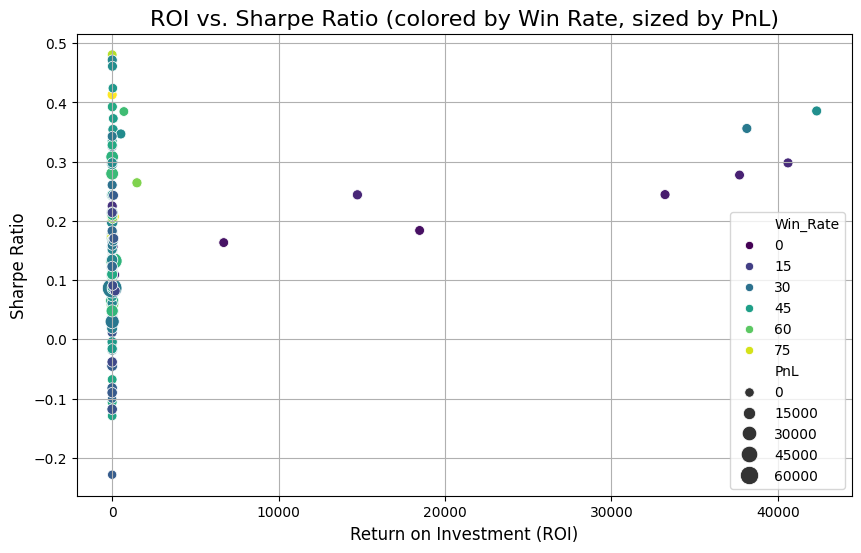

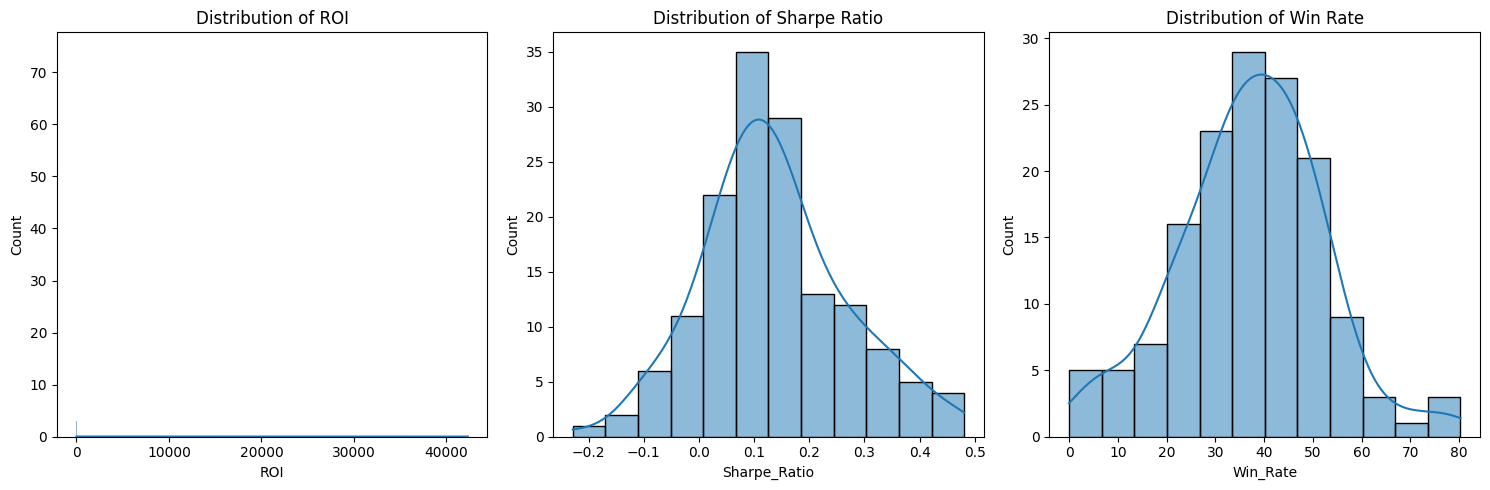

<ipython-input-30-42869ad962ef>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Port_IDs', y='ROI', data=top_20_accounts, palette='magma')


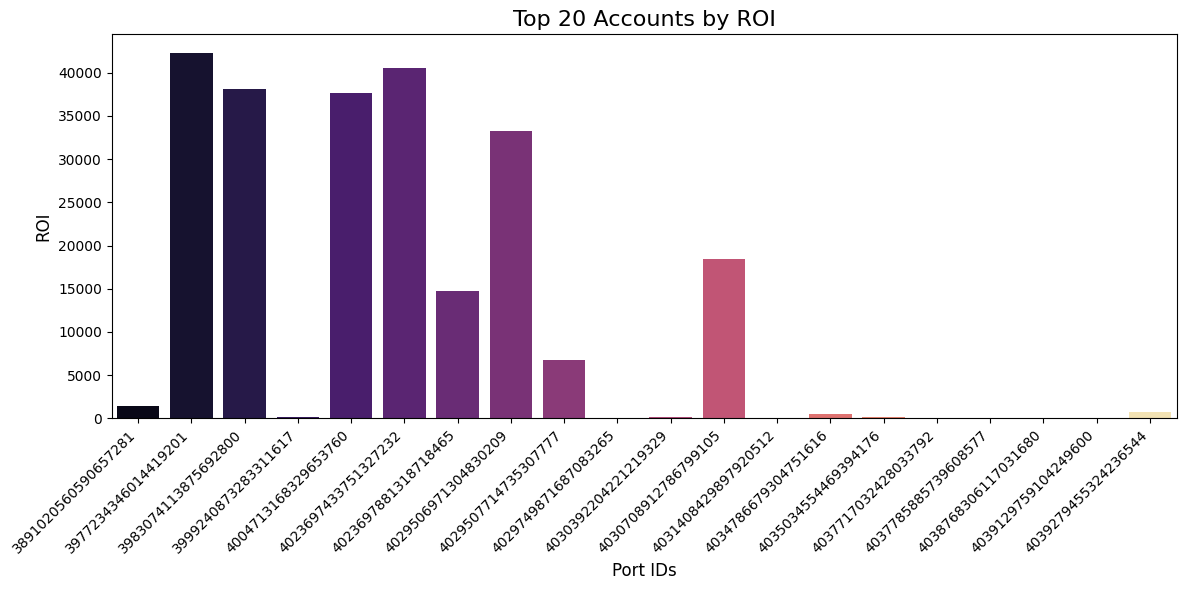

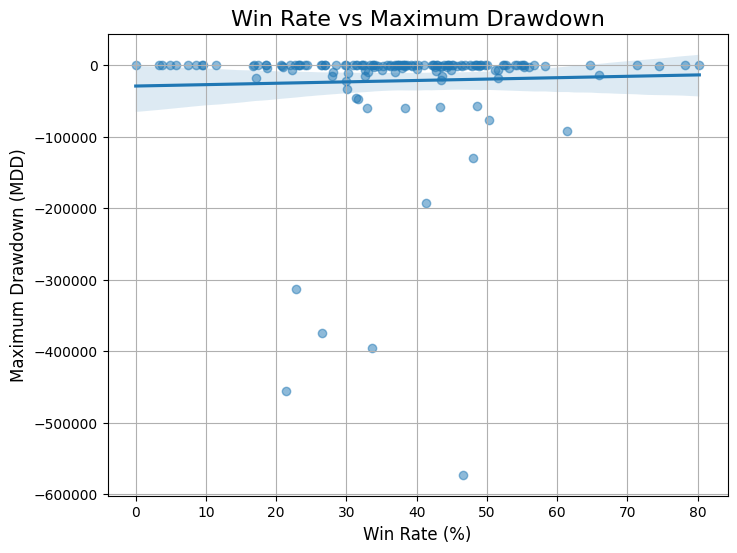

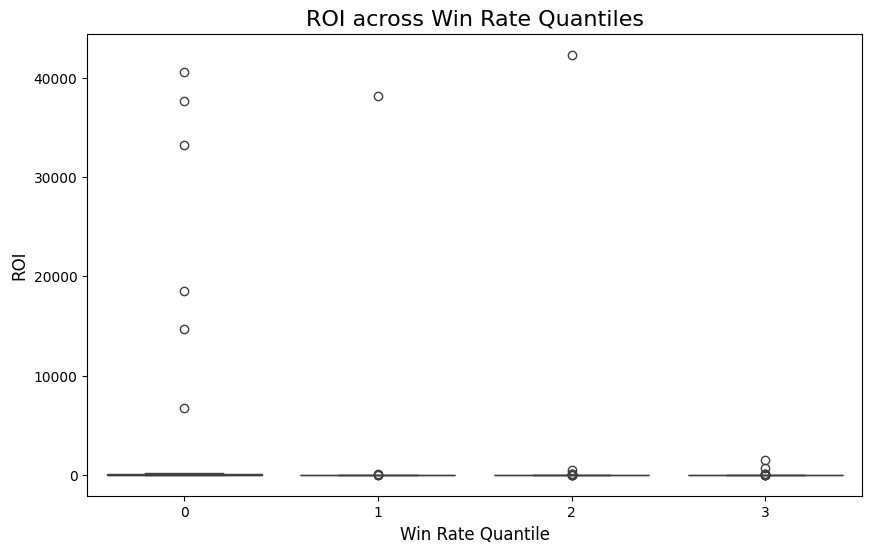

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ROI vs. Sharpe Ratio Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ROI', y='Sharpe_Ratio', data=trade_metrics, hue='Win_Rate', palette='viridis', size='PnL', sizes=(20, 200))
plt.title('ROI vs. Sharpe Ratio (colored by Win Rate, sized by PnL)', fontsize=16)
plt.xlabel('Return on Investment (ROI)', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.grid(True)
plt.show()


# 2.  Distribution of Key Metrics (ROI, Sharpe Ratio, Win Rate)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(trade_metrics['ROI'], kde=True)
plt.title('Distribution of ROI')

plt.subplot(1, 3, 2)
sns.histplot(trade_metrics['Sharpe_Ratio'], kde=True)
plt.title('Distribution of Sharpe Ratio')


plt.subplot(1, 3, 3)
sns.histplot(trade_metrics['Win_Rate'], kde=True)
plt.title('Distribution of Win Rate')

plt.tight_layout()
plt.show()


# 3.  Top 20 Accounts - Bar Plot of ROI
plt.figure(figsize=(12, 6))
sns.barplot(x='Port_IDs', y='ROI', data=top_20_accounts, palette='magma')
plt.title('Top 20 Accounts by ROI', fontsize=16)
plt.xlabel('Port IDs', fontsize=12)
plt.ylabel('ROI', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


# 4.  Relationship between Win Rate and MDD
plt.figure(figsize=(8, 6))
sns.regplot(x='Win_Rate', y='MDD', data=trade_metrics, scatter_kws={'alpha': 0.5})  # Add a regression line
plt.title('Win Rate vs Maximum Drawdown', fontsize=16)
plt.xlabel('Win Rate (%)', fontsize=12)
plt.ylabel('Maximum Drawdown (MDD)', fontsize=12)
plt.grid(True)
plt.show()


# 5.  Boxplot of ROI across different quantiles of Win Rate
trade_metrics['Win_Rate_Quantile'] = pd.qcut(trade_metrics['Win_Rate'], 4, labels=False)  # Divide win rates into 4 quantiles
plt.figure(figsize=(10, 6))
sns.boxplot(x='Win_Rate_Quantile', y='ROI', data=trade_metrics)
plt.title('ROI across Win Rate Quantiles', fontsize=16)
plt.xlabel('Win Rate Quantile', fontsize=12)
plt.ylabel('ROI', fontsize=12)
plt.show()

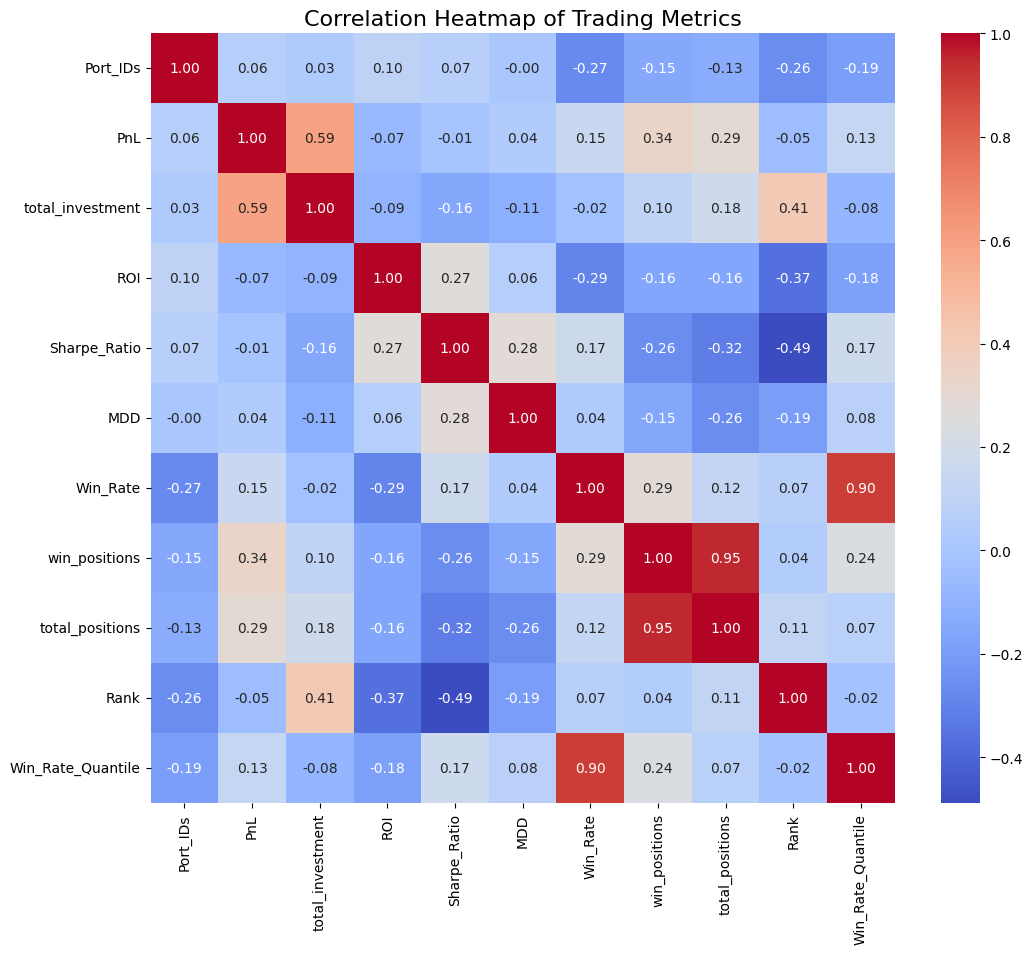

In [31]:
# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(trade_metrics.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Trading Metrics', fontsize=16)
plt.show()

**Step 5: Save Deliverables**

In [32]:
# Save the metrics and top 20 accounts
trade_metrics.to_csv('/content/Trade_Metrics.csv', index=False)
top_20_accounts.to_csv('/content/Top_20_Accounts.csv', index=False)